# Sentinel 2 Waterbodies <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers)

## Background

[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies) is a time-series data product that summarises the surface area of open waterbodies in Australia using [Water Observations from Space (WOfS)](https://www.ga.gov.au/dea/products/wofs). WOfS classifies Landsat pixels into wet and dry. Landsat data have a resolution of 25m$^2$, but it would be really nice if we could instead use Sentinel 2 data with its 10m$^2$ resolution. This would help distinguish neighbouring waterbodies that are blurred together in Landsat (and hence in DEA Waterbodies). Sentinel 2 does not yet have WOfS.

One alternative to WOfS that we _could_ evaluate for Sentinel 2 is the modified normalised difference water index (MNDWI), which can be calculated directly from surface reflectance. MNDWI greater than zero is indicative of water. It is not as accurate as WOfS, but easier to obtain.

## Description
This notebook compares DEA Waterbodies derived from WOfS to an analogous product derived from MNDWI. There are two main factors we can vary: how to derive our polygons, and how to derive our time series. Both polygons and time series can be generated from Landsat WOfS, from Landsat MNDWI, or from Sentinel 2 MNDWI. We can choose to combine any polygon method and any time series method. This gives us a grid of possible evaluations:

| | Landsat WOfS polygons | Landsat MNDWI polygons | Sentinel 2 MNDWI polygons |
|-|---------------|------------------------|---------------------------|
|**Landsat WOfS time series** | DEA Waterbodies | Polygon proxy quality | Good differentation for merged waterbodies |
|**Landsat MNDWI time series** | Time series proxy quality | Total proxy quality | - |
|**Sentinel 2 MNDWI time series** | Sentinel 2 proxy quality | - | Highest resolution |

The upper corner is simply the existing DEA Waterbodies. Polygons derived from Sentinel 2 would be great for differentiating neighbouring waterbodies, even with lower resolution surface area data. Landsat WOfS polygons with MNDWI time series informs us how well MNDWI approximates the surface area time series. Similarly, Landsat MNDWI polygons with WOfS time series informs us how well the MNDWI polygons approximate those we obtain from WOfS. The highest attainable resolution is deriving both parts of the product from Sentinel 2.

***

## Getting started

Edit the analysis parameters and run all the cells in this notebook to analyse a region of Australia.

### Analysis parameters

Choose which area of Australia to analyse:

In [1]:
bbox = xlim, ylim = ((143.70774, 143.89147), (-35.71674, -35.48853))  # Kerang Wetlands

### Load packages
Import Python packages that are used for the analysis.

In [613]:
pip install rioxarray disjoint-set

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [614]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.features
import xarray as xr
import datacube.virtual as virtual
from odc.ui import with_ui_cbk
import rioxarray
import shapely
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib.cm
from disjoint_set import DisjointSet

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map
from dea_spatialtools import xr_rasterize

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='Sentinel2Waterbodies')

## Check the analysis area

Display a map of the area we plan to analyse.

In [4]:
display_map(x=xlim, y=ylim)

## Build a virtual product for the MNDWI calculation

The MNDWI (DOI:10.1080/01431160600589179) is given by

$$
    \frac{\mathrm{green} - \mathrm{SWIR}}{\mathrm{green} + \mathrm{SWIR}}.
$$

We'll build a virtual product that calculates this without having to load all of the channels ourselves. That's easiest with YAML:

In [254]:
cat_yaml = '''
products:
    ls8_MNDWI:
        recipe:
            transform: expressions
            output:
                MNDWI:
                    formula: (green - swir1) / (green + swir1)
                    dtype: float32
            input:
                transform: apply_mask
                mask_measurement_name: fmask
                input:
                    transform: expressions
                    output:
                        fmask: 
                            formula: fmask
                            nodata: False
                        green: green
                        swir1: swir1
                    input:
                          product: ga_ls8c_ard_3
                          measurements: [green, swir1, fmask]
                          output_crs: EPSG:3577
                          resolution: [-30, 30]
                          resampling:
                              fmask: nearest
                              '*': average
    s2a_MNDWI:
        recipe:
            transform: expressions
            output:
                MNDWI:
                    formula: (nbart_green - nbart_swir_2) / (nbart_green + nbart_swir_2)
                    dtype: float32
            input:
                transform: apply_mask
                mask_measurement_name: fmask
                input:
                    transform: expressions
                    output:
                        fmask: 
                            formula: (fmask == 1) | (fmask == 5)
                            nodata: False
                        nbart_green: nbart_green
                        nbart_swir_2: nbart_swir_2
                    input:
                        collate:
                            - product: s2b_ard_granule
                              measurements: [nbart_green, nbart_swir_2, fmask]
                              output_crs: EPSG:3577
                              resolution: [-10, 10]
                              resampling:
                                  fmask: nearest
                                  '*': average
                            - product: s2a_ard_granule
                              measurements: [nbart_green, nbart_swir_2, fmask]
                              output_crs: EPSG:3577
                              resolution: [-10, 10]
                              resampling:
                                  fmask: nearest
                                  '*': average
    wofs_masked:
        recipe:
            transform: expressions
            output:
                water:
                    formula: water
                    nodata: -1
            input:
                transform: apply_mask
                mask_measurement_name: mask
                input:
                    transform: expressions
                    output:
                        mask: 
                            formula: (water == 0) | (water == 128)
                            nodata: False
                        water:
                            formula: water
                            nodata: -1
                    input:
                        product: wofs_albers
                        measurements: [water]
                        output_crs: EPSG:3577
                        resolution: [-25, 25]
'''

In [255]:
cat = virtual.catalog_from_yaml(cat_yaml)

In [53]:
dask_chunks = {'x': 3000, 'y': 3000, 'time': 1}
s2a_mndwi = cat['s2a_MNDWI'].load(dc, x=xlim, y=ylim, time=('2015-11', '2020-09'), group_by='solar_day', dask_chunks=dask_chunks)
ls8_mndwi = cat['ls8_MNDWI'].load(dc, x=xlim, y=ylim, time=('2015-11', '2020-09'), group_by='solar_day', dask_chunks=dask_chunks)

In [268]:
times = [
    str(t.values) for t in ls8_mndwi.time
]

wofs = cat['wofs_masked'].load(dc, x=xlim, y=ylim, time=times, dask_chunks=dask_chunks)  # Matches LS8 time
wofs = xr.where(wofs == 128, 1, xr.where(wofs == 0, 0, np.nan))

## Calculate an all-time average

In analogy to WOfS all-time summary, calculate an all-time average for both MNDWIs.

In [55]:
s2a_mndwi_mean = s2a_mndwi.MNDWI.mean(axis=0).load()

In [56]:
ls8_mndwi_mean = ls8_mndwi.MNDWI.mean(axis=0).load()

Text(0.5, 1.0, 'LS8')

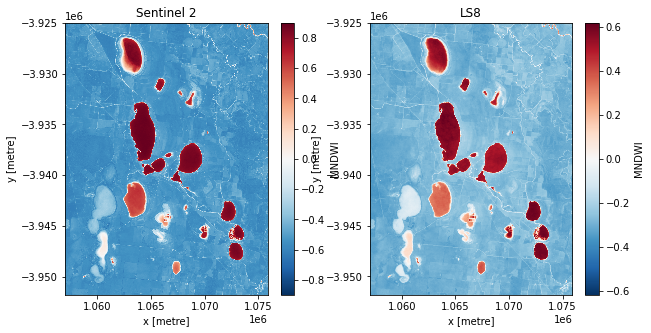

In [57]:
fig, (l, r) = plt.subplots(1, 2, figsize=(10, 5))
s2a_mndwi_mean.plot.imshow(ax=l)
ls8_mndwi_mean.plot.imshow(ax=r)
l.set_title('Sentinel 2')
r.set_title('LS8')

Note that this is *not* the only way to aggregate MNDWI. We could also threshold it daily and then aggregate, which would be a lot closer to WOfS. Let's try that too.

In [58]:
s2a_mndwi_summary = (s2a_mndwi.MNDWI >= 0).mean(axis=0).load()

In [59]:
ls8_mndwi_summary = (ls8_mndwi.MNDWI >= 0).mean(axis=0).load()

Text(0.5, 1.0, 'LS8 average water')

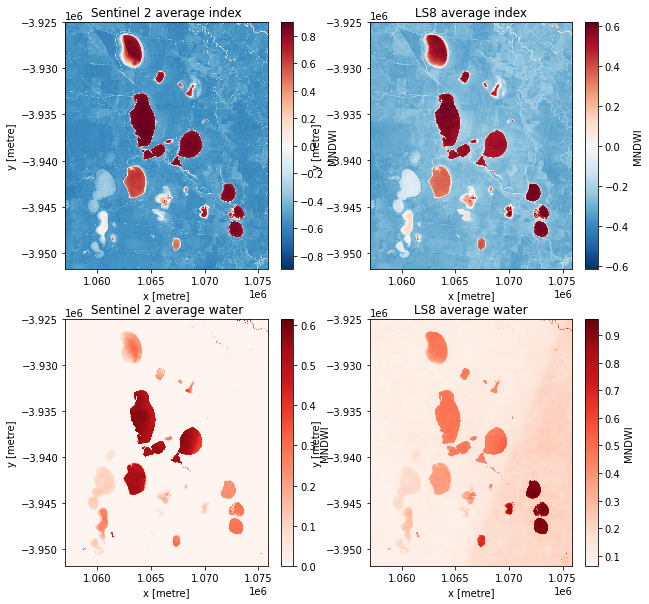

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
s2a_mndwi_mean.plot.imshow(ax=axs[0, 0])
ls8_mndwi_mean.plot.imshow(ax=axs[0, 1])
s2a_mndwi_summary.plot.imshow(ax=axs[1, 0], cmap='Reds')
ls8_mndwi_summary.plot.imshow(ax=axs[1, 1], cmap='Reds')
axs[0, 0].set_title('Sentinel 2 average index')
axs[0, 1].set_title('LS8 average index')
axs[1, 0].set_title('Sentinel 2 average water')
axs[1, 1].set_title('LS8 average water')

This looks pretty good actually. The waterbodies to the left in S2 are much clearer.

Let's repeat this for WOfS.

In [273]:
wofs_summary = wofs.water.mean(axis=0).load()

Text(0.5, 1.0, 'WOfS average water')

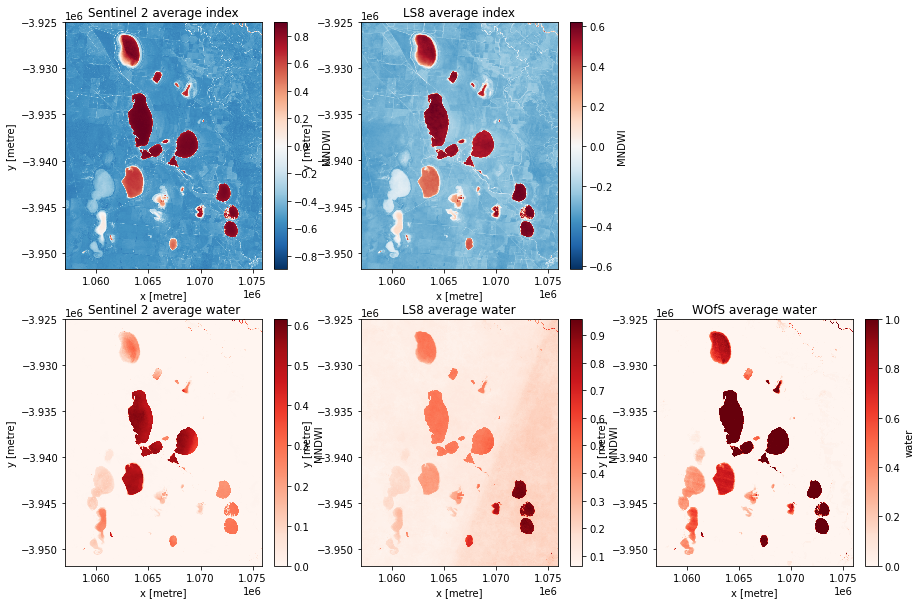

In [274]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
s2a_mndwi_mean.plot.imshow(ax=axs[0, 0])
ls8_mndwi_mean.plot.imshow(ax=axs[0, 1])
s2a_mndwi_summary.plot.imshow(ax=axs[1, 0], cmap='Reds')
ls8_mndwi_summary.plot.imshow(ax=axs[1, 1], cmap='Reds')
wofs_summary.plot.imshow(ax=axs[1, 2], cmap='Reds')
axs[0, 0].set_title('Sentinel 2 average index')
axs[0, 1].set_title('LS8 average index')
axs[0, 2].axis('off')
axs[1, 0].set_title('Sentinel 2 average water')
axs[1, 1].set_title('LS8 average water')
axs[1, 2].set_title('WOfS average water')

## Generating polygons

We can generate polygons by judicious choice of threshold for each of these. TODO: Use an adaptive threshold.

The existing method for DEA Waterbodies is to generate polygons at the 10% level as well as the 5% level. Then, use the 5% polygons joined with the 10% polygons. We'll just use 5% for simplicity.

The LS8 image looks a lot worse, so we'll instead use the mean index and see if it's greater than -0.15.

What do these look like?

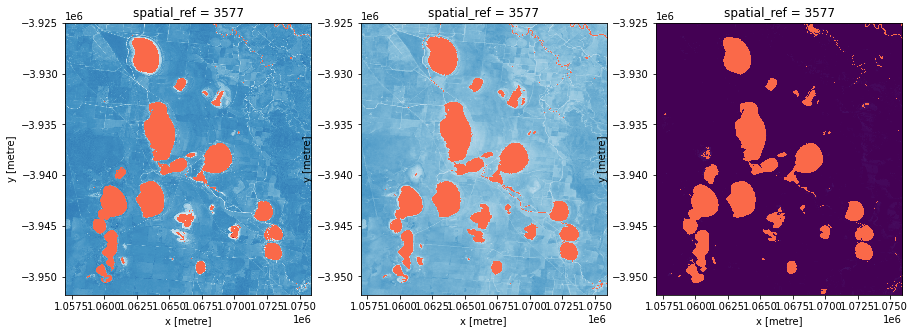

In [797]:
fig, (l, m, r) = plt.subplots(1, 3, figsize=(15, 5))
s2a_water = s2a_mndwi_summary >= 0.05
ls8_water = ls8_mndwi_mean >= -0.15
wofs_water = wofs_summary >= 0.05
s2a_mndwi_mean.plot.imshow(ax=l, add_colorbar=False)
xr.where(s2a_water, 1, np.nan).plot.imshow(cmap='Reds', add_colorbar=False, ax=l)
ls8_mndwi_mean.plot.imshow(ax=m, add_colorbar=False)
xr.where(ls8_water, 1, np.nan).plot.imshow(cmap='Reds', add_colorbar=False, ax=m)
wofs_summary.plot.imshow(ax=r, add_colorbar=False)
xr.where(wofs_water, 1, np.nan).plot.imshow(cmap='Reds', add_colorbar=False, ax=r)

In [798]:
def mask_to_polygons(mask):
    s2a_polygons = rasterio.features.shapes(
               mask.data.astype('float32'),
               mask=mask.data.astype('float32') == 1,
               transform=mask.rio.transform())
    s2a_polygons = [shapely.geometry.MultiPolygon([shapely.geometry.Polygon(cs) for cs in s['coordinates']]) for s, _ in s2a_polygons]
    return gpd.GeoDataFrame(geometry=s2a_polygons)

In [799]:
s2a_wbs = mask_to_polygons(s2a_water)

In [800]:
ls8_wbs = mask_to_polygons(ls8_water)

In [801]:
wofs_wbs = mask_to_polygons(wofs_water)

Sort all of these by longitude and reindex.

In [802]:
s2a_wbs['lon'] = s2a_wbs.centroid.x
ls8_wbs['lon'] = ls8_wbs.centroid.x
wofs_wbs['lon'] = wofs_wbs.centroid.x

s2a_wbs = s2a_wbs.sort_values('lon').reset_index(drop=True)
ls8_wbs = ls8_wbs.sort_values('lon').reset_index(drop=True)
wofs_wbs = wofs_wbs.sort_values('lon').reset_index(drop=True)

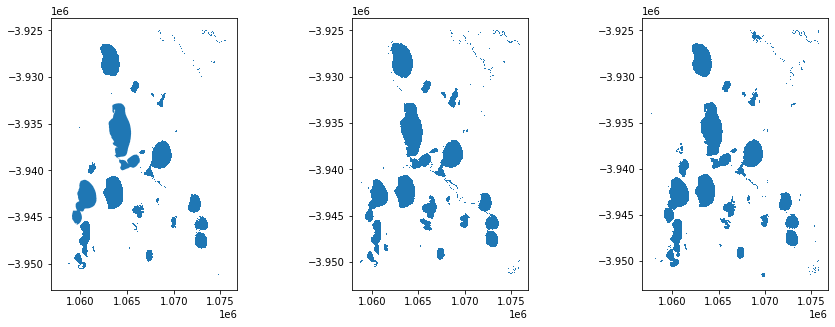

In [803]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for wbs, ax in zip([s2a_wbs, ls8_wbs, wofs_wbs], axs):
    wbs.plot(ax=ax)

In [804]:
len(s2a_wbs), len(ls8_wbs), len(wofs_wbs)

(516, 264, 396)

We need to associate the polygons in each set. This is a difficult problem in general (see: my PhD), but we'll naively clique them.

Visualise this cliquing (this is why we had to sort earlier):

In [805]:
s2a_wbs_joined = gpd.sjoin(s2a_wbs, wofs_wbs, how='left', lsuffix='s2', rsuffix='wofs')
ls8_wbs_joined = gpd.sjoin(ls8_wbs, wofs_wbs, how='left', lsuffix='ls8', rsuffix='wofs')

In [806]:
colours = matplotlib.cm.rainbow(np.linspace(0, 1, len(wofs_wbs)))
np.random.shuffle(colours)

Text(0.5, 0, 'Index')

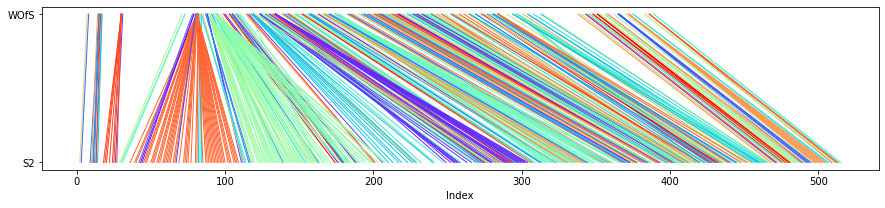

In [807]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for row in s2a_wbs_joined.itertuples():
    if np.isnan(row.index_wofs):
        continue
    plt.plot([row.Index, row.index_wofs], [0, 1], c=colours[int(row.index_wofs)], linewidth=1)
plt.yticks([0, 1], ['S2', 'WOfS'])
plt.xlabel('Index')

Use a disjoint set to aggregate.

In [808]:
# s2_ds = DisjointSet()
# for row in s2a_wbs_joined.itertuples():
#     if np.isnan(row.index_wofs):
#         continue
#     s2_name = row.Index
#     wofs_name = int(row.index_wofs + len(s2a_wbs))
#     s2_ds.union(s2_name, wofs_name)

# s2a_wbs_merged = []
# for s in s2_ds.itersets():
#     s2_ids = []
#     wofs_ids = []
#     s2_geom = []
#     for poly in s:
#         if poly >= len(s2a_wbs):
#             # WOfS polygon.
#             wofs_ids.append(poly - len(s2a_wbs))
#             continue
#         s2_geom.append(s2a_wbs.loc[poly])
#         s2_ids.append(poly)
#     new = {
#         'geometry': s2a_wbs.loc[s2_ids].geometry.buffer(0).unary_union,
#         's2_ids': ','.join(map(str, set(s2_ids))),
#         'wofs_ids': ','.join(map(str, set(wofs_ids))),
#     }
#     s2a_wbs_merged.append(new)
# len(s2a_wbs_merged)

# ls8_ds = DisjointSet()
# for row in ls8_wbs_joined.itertuples():
#     if np.isnan(row.index_wofs):
#         continue
#     ls8_name = row.Index
#     wofs_name = int(row.index_wofs + len(ls8_wbs))
#     ls8_ds.union(ls8_name, wofs_name)

# ls8_wbs_merged = []
# for s in ls8_ds.itersets():
#     ls8_ids = []
#     wofs_ids = []
#     ls8_geom = []
#     for poly in s:
#         if poly >= len(ls8_wbs):
#             # WOfS polygon.
#             wofs_ids.append(poly - len(ls8_wbs))
#             continue
#         ls8_geom.append(ls8_wbs.loc[poly])
#         ls8_ids.append(poly)
#     new = {
#         'geometry': ls8_wbs.loc[ls8_ids].geometry.buffer(0).unary_union,
#         'ls8_ids': ','.join(map(str, set(ls8_ids))),
#         'wofs_ids': ','.join(map(str, set(wofs_ids))),
#     }
#     ls8_wbs_merged.append(new)
# len(ls8_wbs_merged)

# s2a_wbs = gpd.GeoDataFrame(s2a_wbs_merged)
# ls8_wbs = gpd.GeoDataFrame(ls8_wbs_merged)

In [809]:
s2a_wbs['ID'] = np.arange(1, len(s2a_wbs) + 1).astype(int)
ls8_wbs['ID'] = np.arange(1, len(ls8_wbs) + 1).astype(int)
wofs_wbs['ID'] = np.arange(1, len(wofs_wbs) + 1).astype(int)

Let's discard everything less than 5 pixels in area. This is 500 m$^2$ for S2, 4500 m$^2$ for LS8, and 3125 m$^2$ for WOfS.

In [810]:
s2a_wbs = s2a_wbs[s2a_wbs.area >= 500]

In [811]:
ls8_wbs = ls8_wbs[ls8_wbs.area >= 4500]

In [812]:
wofs_wbs = wofs_wbs[wofs_wbs.area >= 3125]

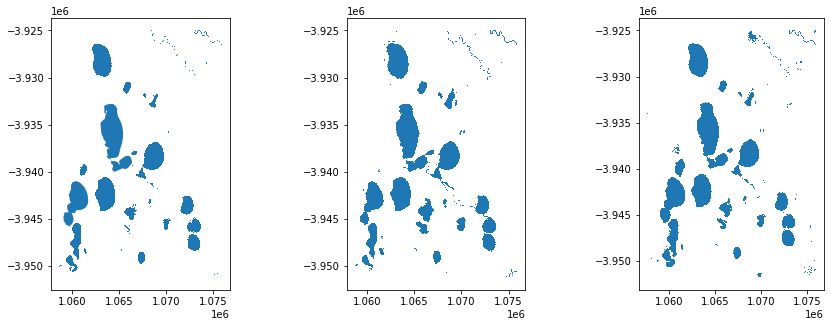

In [813]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for wbs, ax in zip([s2a_wbs, ls8_wbs, wofs_wbs], axs):
    wbs.plot(ax=ax)

Finally give everything a new ID.

In [814]:
s2a_wbs['ID'] = np.arange(1, len(s2a_wbs) + 1).astype(int)
ls8_wbs['ID'] = np.arange(1, len(ls8_wbs) + 1).astype(int)

In [815]:
wofs_wbs['ID'] = np.arange(1, len(wofs_wbs) + 1).astype(int)

## Generating time series

Given each set of polygons, count how many pixels are wet, dry, or invalid for each observation. To save time loading data, do all polygon sets at the same time for each time slice.

Convert every polygon into a raster mask.

In [816]:
s2a_wofs_masks = xr_rasterize(s2a_wbs.set_crs('EPSG:3577'), wofs.water.isel(time=0), attribute_col='ID')
ls8_wofs_masks = xr_rasterize(ls8_wbs.set_crs('EPSG:3577'), wofs.water.isel(time=0), attribute_col='ID')
wofs_wofs_masks = xr_rasterize(wofs_wbs.set_crs('EPSG:3577'), wofs.water.isel(time=0), attribute_col='ID')

Rasterizing to match xarray.DataArray dimensions (1072, 757)
Rasterizing to match xarray.DataArray dimensions (1072, 757)
Rasterizing to match xarray.DataArray dimensions (1072, 757)


In [817]:
s2a_wofs_ts = np.zeros((len(s2a_wbs), len(wofs.water)))
ls8_wofs_ts = np.zeros((len(ls8_wbs), len(wofs.water)))
wofs_wofs_ts = np.zeros((len(wofs_wbs), len(wofs.water)))
s2a_wofs_invalid_ts = np.zeros((len(s2a_wbs), len(wofs.water)))
ls8_wofs_invalid_ts = np.zeros((len(ls8_wbs), len(wofs.water)))
wofs_wofs_invalid_ts = np.zeros((len(wofs_wbs), len(wofs.water)))
for t, time_slice in enumerate(tqdm(wofs.water)):
    time_slice = time_slice.values
    for i in range(1, len(s2a_wbs) + 1):
        sl = time_slice[s2a_wofs_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        s2a_wofs_ts[i - 1, t] = n_wet
        s2a_wofs_invalid_ts[i - 1, t] = n_invalid
    for i in range(1, len(ls8_wbs) + 1):
        sl = time_slice[ls8_wofs_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        ls8_wofs_ts[i - 1, t] = n_wet
        ls8_wofs_invalid_ts[i - 1, t] = n_invalid
    for i in range(1, len(wofs_wbs) + 1):
        sl = time_slice[wofs_wofs_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        wofs_wofs_ts[i - 1, t] = n_wet
        wofs_wofs_invalid_ts[i - 1, t] = n_invalid

In [818]:
s2a_ls8_masks = xr_rasterize(s2a_wbs.set_crs('EPSG:3577'), ls8_mndwi.MNDWI.isel(time=0), attribute_col='ID')
ls8_ls8_masks = xr_rasterize(ls8_wbs.set_crs('EPSG:3577'), ls8_mndwi.MNDWI.isel(time=0), attribute_col='ID')
wofs_ls8_masks = xr_rasterize(wofs_wbs.set_crs('EPSG:3577'), ls8_mndwi.MNDWI.isel(time=0), attribute_col='ID')

Rasterizing to match xarray.DataArray dimensions (894, 631)
Rasterizing to match xarray.DataArray dimensions (894, 631)
Rasterizing to match xarray.DataArray dimensions (894, 631)


In [1007]:
s2a_ls8_ts = np.zeros((len(s2a_wbs), len(ls8_mndwi.MNDWI)))
ls8_ls8_ts = np.zeros((len(ls8_wbs), len(ls8_mndwi.MNDWI)))
wofs_ls8_ts = np.zeros((len(wofs_wbs), len(ls8_mndwi.MNDWI)))
s2a_ls8_invalid_ts = np.zeros((len(s2a_wbs), len(ls8_mndwi.MNDWI)))
ls8_ls8_invalid_ts = np.zeros((len(ls8_wbs), len(ls8_mndwi.MNDWI)))
wofs_ls8_invalid_ts = np.zeros((len(wofs_wbs), len(ls8_mndwi.MNDWI)))
for t, time_slice in enumerate(tqdm(ls8_mndwi.MNDWI)):
    time_slice = time_slice.values
    time_slice = np.where(np.isnan(time_slice), np.nan, time_slice > 0)
    for i in range(1, len(s2a_wbs) + 1):
        sl = time_slice[s2a_ls8_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        s2a_ls8_ts[i - 1, t] = n_wet
        s2a_ls8_invalid_ts[i - 1, t] = n_invalid
    for i in range(1, len(ls8_wbs) + 1):
        sl = time_slice[ls8_ls8_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        ls8_ls8_ts[i - 1, t] = n_wet
        ls8_ls8_invalid_ts[i - 1, t] = n_invalid
    for i in range(1, len(wofs_wbs) + 1):
        sl = time_slice[wofs_ls8_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        wofs_ls8_ts[i - 1, t] = n_wet
        wofs_ls8_invalid_ts[i - 1, t] = n_invalid

In [820]:
s2a_s2a_masks = xr_rasterize(s2a_wbs.set_crs('EPSG:3577'), s2a_mndwi.MNDWI.isel(time=0), attribute_col='ID')
ls8_s2a_masks = xr_rasterize(ls8_wbs.set_crs('EPSG:3577'), s2a_mndwi.MNDWI.isel(time=0), attribute_col='ID')
wofs_s2a_masks = xr_rasterize(wofs_wbs.set_crs('EPSG:3577'), s2a_mndwi.MNDWI.isel(time=0), attribute_col='ID')

Rasterizing to match xarray.DataArray dimensions (2679, 1890)
Rasterizing to match xarray.DataArray dimensions (2679, 1890)
Rasterizing to match xarray.DataArray dimensions (2679, 1890)


In [821]:
s2a_s2a_ts = np.zeros((len(s2a_wbs), len(s2a_mndwi.MNDWI)))
ls8_s2a_ts = np.zeros((len(ls8_wbs), len(s2a_mndwi.MNDWI)))
wofs_s2a_ts = np.zeros((len(wofs_wbs), len(s2a_mndwi.MNDWI)))
s2a_s2a_invalid_ts = np.zeros((len(s2a_wbs), len(s2a_mndwi.MNDWI)))
ls8_s2a_invalid_ts = np.zeros((len(ls8_wbs), len(s2a_mndwi.MNDWI)))
wofs_s2a_invalid_ts = np.zeros((len(wofs_wbs), len(s2a_mndwi.MNDWI)))
for t, time_slice in enumerate(tqdm(s2a_mndwi.MNDWI)):
    time_slice = time_slice.values
    for i in range(1, len(s2a_wbs) + 1):
        sl = time_slice[s2a_s2a_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        s2a_s2a_ts[i - 1, t] = n_wet
        s2a_s2a_invalid_ts[i - 1, t] = n_invalid
    for i in range(1, len(ls8_wbs) + 1):
        sl = time_slice[ls8_s2a_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        ls8_s2a_ts[i - 1, t] = n_wet
        ls8_s2a_invalid_ts[i - 1, t] = n_invalid
    for i in range(1, len(wofs_wbs) + 1):
        sl = time_slice[wofs_s2a_masks == i]
        n_wet = np.nansum(sl)
        n_invalid = np.isnan(sl).sum()
        wofs_s2a_ts[i - 1, t] = n_wet
        wofs_s2a_invalid_ts[i - 1, t] = n_invalid

## Comparing time series

To begin with, let's visually examine some of the larger waterbodies.

### LS8 polygons

In [1140]:
biggest = list(ls8_extents.argsort() + 1)

In [1141]:
biggest = biggest[-2]

In [1142]:
ls8_ls8_df = gpd.pd.DataFrame(ls8_ls8_ts.T, columns=ls8_wbs.ID)
ls8_ls8_df.index = ls8_mndwi.time.values
ls8_ls8_invalid_df = gpd.pd.DataFrame(ls8_ls8_invalid_ts.T, columns=ls8_wbs.ID)
ls8_ls8_invalid_df.index = ls8_mndwi.time.values

ls8_wofs_df = gpd.pd.DataFrame(ls8_wofs_ts.T, columns=ls8_wbs.ID)
ls8_wofs_df.index = wofs.time.values
ls8_wofs_invalid_df = gpd.pd.DataFrame(ls8_wofs_invalid_ts.T, columns=ls8_wbs.ID)
ls8_wofs_invalid_df.index = wofs.time.values

ls8_s2a_df = gpd.pd.DataFrame(ls8_s2a_ts.T, columns=ls8_wbs.ID)
ls8_s2a_df.index = s2a_mndwi.time.values
ls8_s2a_invalid_df = gpd.pd.DataFrame(ls8_s2a_invalid_ts.T, columns=ls8_wbs.ID)
ls8_s2a_invalid_df.index = s2a_mndwi.time.values

In [1143]:
ls8_extents = ls8_wbs.set_index('ID').area / 30 ** 2

In [1144]:
ls8_ls8_invalid_pc = ls8_ls8_invalid_df / ls8_extents
ls8_wofs_invalid_pc = ls8_wofs_invalid_df / ls8_extents
ls8_s2a_invalid_pc = ls8_s2a_invalid_df / ls8_extents

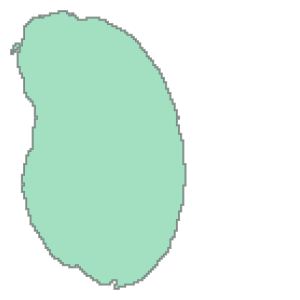

In [1148]:
ls8_wbs.iloc[biggest - 1].geometry

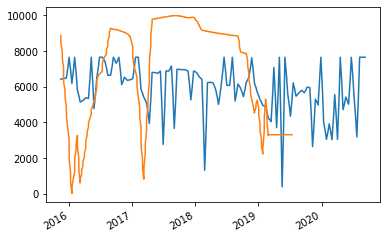

In [1145]:
fig, ax = plt.subplots()
series = ls8_ls8_df[biggest]
series[ls8_ls8_invalid_pc[biggest] > 0.1] = np.nan
series.interpolate().plot(ax=ax)
series = ls8_wofs_df[biggest]
series[ls8_wofs_invalid_pc[biggest] > 0.1] = np.nan
series.interpolate().plot(ax=ax)
# series = ls8_s2a_df[biggest]
# series[ls8_s2a_invalid_pc[biggest] > 0.1] = np.nan
# series.interpolate().plot(ax=ax)

### WOfS polygons

In [911]:
wofs_wbs_ = wofs_wbs.set_index('ID')

In [912]:
k = 50

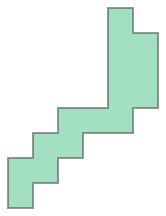

In [913]:
wofs_wbs_.loc[k].geometry

In [914]:
wofs_dates = wofs.time.values

In [915]:
wofs_wofs_df = gpd.pd.DataFrame(wofs_wofs_ts.T)

In [916]:
wofs_wofs_df.index = gpd.pd.DatetimeIndex(wofs_dates)

In [917]:
wofs_max_extent.shape

(128,)

In [918]:
wofs_max_extent = wofs_wbs.area / 25 ** 2
wofs_wofs_pc = (wofs_wofs_invalid_ts.T / wofs_max_extent[None, :])
wofs_wofs_ok = wofs_wofs_pc <= 0.1

In [919]:
wofs_wofs_pc.max()

1.0

In [920]:
wofs_wofs_df[~wofs_wofs_ok] = np.nan

In [925]:
wofs_wofs_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
2015-11-15 00:15:07.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-15 00:15:31.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-16 00:09:57.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-23 00:16:14.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-24 00:09:23.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-28 00:09:07.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-05 00:14:56.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-05 00:15:20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-13 00:03:58.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [921]:
wofs_wofs_lower = wofs_wofs_df
wofs_wofs_upper = wofs_wofs_df + np.where(wofs_wofs_ok, wofs_wofs_invalid_ts.T, 0)

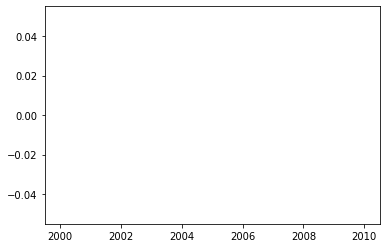

In [924]:
plt.plot(wofs_wofs_lower[25].interpolate())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [79]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)